Roadmap 

---

## 1️⃣ Environment & Library Setup                  

* Python environment setup
* Required library import
* Version compatibility check

---

## 2️⃣ `.dat` File Reading

* File path handling
* `.dat` delimiter detection
* Raw data loading
* Column assignment
* Data type conversion

---

## 3️⃣ Label Creation

* Activity–label mapping
* Label encoding
* Class index verification

---

## 4️⃣ Dataset Merging

* Multiple `.dat` file concatenation
* Unified dataframe creation
* Index reset

---

## 5️⃣ Initial Data Inspection

* Dataset shape check
* Column name verification
* First & last rows preview

---

## 6️⃣ EDA (Exploratory Data Analysis)

* Class distribution analysis
* Feature summary statistics
* Missing value check
* Duplicate sample check

### 📊 EDA Plots

* Activity count bar plot
* Sensor signal line plot
* Feature histogram
* Box plot (outliers)
* Correlation heatmap

---

## 7️⃣ Data Cleaning

* Missing value handling
* Noise smoothing
* Signal filtering
* Outlier handling

---

## 8️⃣ Signal Segmentation

* Window size definition
* Overlap definition
* Sliding window generation
* Window-wise label assignment

---

## 9️⃣ Feature Extraction (ML Mandatory)

### Time-Domain Features

* Mean
* Standard deviation
* Variance
* RMS
* Min / Max

### Frequency-Domain Features

* FFT coefficients
* Spectral energy
* Entropy

---

## 🔟 Feature Dataset Construction

* Window-wise feature vector creation
* Feature–label alignment
* Final ML-ready dataframe

---

## 1️⃣1️⃣ Feature Scaling

* StandardScaler
* MinMaxScaler
* Scaler persistence

---

## 1️⃣2️⃣ Train–Test Split

* Stratified split
* Random state fixation

---

## 1️⃣3️⃣ LightGBM Data Preparation

* LightGBM Dataset object creation
* Categorical feature handling

---

## 1️⃣4️⃣ LightGBM Model Configuration

* Objective selection
* Number of classes
* Learning rate
* Number of leaves
* Max depth
* Boosting type

---

## 1️⃣5️⃣ Model Training

* Model fitting
* Validation set usage
* Early stopping

---

## 1️⃣6️⃣ Model Prediction

* Class prediction
* Probability prediction

---

## 1️⃣7️⃣ Model Evaluation

* Accuracy score
* Precision
* Recall
* F1-score

### 📊 Evaluation Plots

* Confusion matrix
* Normalized confusion matrix
* Feature importance plot

---

## 1️⃣8️⃣ Error Analysis

* Misclassification analysis
* Class-wise error inspection

---

## 1️⃣9️⃣ Result Visualization

* Actual vs predicted plot
* Activity-wise accuracy bar chart









# Human Activity Recognition
## Name : Hossain Md Ismail
### ID : 228801140

# 1️⃣ Environment & Library Setup
## 🔹 Description

This step prepares the Python working environment required for the Human Activity Recognition (HAR) project.
All necessary libraries for data loading, preprocessing, visualization, signal processing, machine learning, and model persistence are installed and imported.
Additionally, Python and library version compatibility is verified to ensure reproducibility and stable execution of the LightGBM model.

In [207]:
!pip install lightgbm seaborn scipy joblib


In [208]:
import os
import glob
import sys
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.signal import savgol_filter
from scipy.fft import fft

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import lightgbm as lgb
import joblib

warnings.filterwarnings("ignore")


## 2️⃣ .dat File Reading

In [209]:
DATA_DIR = "data/"   # change this to your dataset folder path
dat_files = glob.glob(os.path.join(DATA_DIR, "*.dat"))

print("Total .dat files found:", len(dat_files))


Total .dat files found: 9


In [210]:
# Inspect the first file to detect delimiter
sample_file = dat_files[0]

with open(sample_file, "r") as f:
    first_line = f.readline()

print("Sample line:", first_line)


Sample line: 8.38 0 104 30 2.37223 8.60074 3.51048 2.43954 8.76165 3.35465 -0.0922174 0.0568115 -0.0158445 14.6806 -69.2128 -5.58905 1 0 0 0 31.8125 0.23808 9.80003 -1.68896 0.265304 9.81549 -1.41344 -0.00506495 -0.00678097 -0.00566295 0.47196 -51.0499 43.2903 1 0 0 0 30.3125 9.65918 -1.65569 -0.0997967 9.64689 -1.55576 0.310404 0.00830026 0.00925038 -0.0175803 -61.1888 -38.9599 -58.1438 1 0 0 0



In [211]:
def load_dat_file(file_path):
    return pd.read_csv(
        file_path,
        sep=r"\s+",
        header=None,
        engine="python"
    )


In [212]:
columns = [
    "timestamp", "activity_id", "heart_rate",

    # IMU Hand (17)
    *[f"hand_{i}" for i in range(1, 18)],

    # IMU Chest (17)
    *[f"chest_{i}" for i in range(1, 18)],

    # IMU Ankle (17)
    *[f"ankle_{i}" for i in range(1, 18)]
]


In [290]:
def preprocess_dat(df):
    df.columns = columns
    df = df.apply(pd.to_numeric, errors="coerce")
    return df


In [214]:
dataframes = []

for file in dat_files:
    df = load_dat_file(file)
    df = preprocess_dat(df)
    df["source_file"] = os.path.basename(file)
    dataframes.append(df)


## 3️⃣ Label Creation

In [215]:
activity_map = {
    1: "Lying",
    2: "Sitting",
    3: "Standing",
    4: "Walking",
    5: "Running",
    6: "Cycling",
    7: "Nordic_Walking",
    9: "Watching_TV",
    10: "Computer_Work",
    11: "Car_Driving",
    12: "Ascending_Stairs",
    13: "Descending_Stairs",
    16: "Vacuum_Cleaning",
    17: "Ironing",
    18: "Folding_Laundry",
    19: "House_Cleaning",
    20: "Playing_Soccer",
    24: "Rope_Jumping"
}


In [216]:
for i in range(len(dataframes)):
    dataframes[i] = dataframes[i][dataframes[i]["activity_id"] != 0]
    dataframes[i]["activity_label"] = dataframes[i]["activity_id"].map(activity_map)


In [217]:
label_encoder = LabelEncoder()

for i in range(len(dataframes)):
    dataframes[i]["activity_encoded"] = label_encoder.fit_transform(
        dataframes[i]["activity_label"]
    )


In [291]:
class_mapping = dict(
    zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))
)

print("Class Index Mapping:")
class_mapping


Class Index Mapping:


{'Rope_Jumping': 0}

## 4️⃣ Dataset Merging
### 🔹 Description

This step merges data from multiple .dat files into a single unified dataset.
All subject-wise DataFrames are concatenated to create one comprehensive DataFrame for analysis and modeling.
After merging, the index is reset to ensure a continuous and clean indexing structure for subsequent processing steps.

In [219]:
full_dataset = pd.concat(dataframes, axis=0)
print("Unified dataset shape:", full_dataset.shape)
full_dataset.reset_index(drop=True, inplace=True)
full_dataset.head()


Unified dataset shape: (1942872, 57)


,timestamp,activity_id,heart_rate,hand_1,hand_2,hand_3,hand_4,hand_5,hand_6,hand_7,...,ankle_11,ankle_12,ankle_13,ankle_14,ankle_15,ankle_16,ankle_17,source_file,activity_label,activity_encoded
0,37.66,1,NaN,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,-61.1081,-36.8636,-58.3696,1.0,0.0,0.0,0.0,subject101.dat,Lying,4
1,37.67,1,NaN,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,-60.8916,-36.3197,-58.3656,1.0,0.0,0.0,0.0,subject101.dat,Lying,4
2,37.68,1,NaN,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,-60.3407,-35.7842,-58.6119,1.0,0.0,0.0,0.0,subject101.dat,Lying,4
3,37.69,1,NaN,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,-60.7646,-37.1028,-57.8799,1.0,0.0,0.0,0.0,subject101.dat,Lying,4
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,-60.2040,-37.1225,-57.8847,1.0,0.0,0.0,0.0,subject101.dat,Lying,4


## 5️⃣ Initial Data Inspection
### 🔹 Description

This step performs an initial inspection of the merged dataset to verify its structural integrity.
It includes checking the overall dataset dimensions, validating column names, and previewing the first and last few rows to ensure that the data has been loaded and merged correctly before proceeding to exploratory data analysis.

In [220]:
print("Dataset Shape (rows, columns):", full_dataset.shape)
print("Column Names:")
full_dataset.columns.tolist()
full_dataset.head()
full_dataset.tail()


Dataset Shape (rows, columns): (1942872, 57)
Column Names:


,timestamp,activity_id,heart_rate,hand_1,hand_2,hand_3,hand_4,hand_5,hand_6,hand_7,...,ankle_11,ankle_12,ankle_13,ankle_14,ankle_15,ankle_16,ankle_17,source_file,activity_label,activity_encoded
1942867,95.06,24,NaN,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,-45.7855,-0.831734,-0.170139,0.522929,-0.291612,0.705786,-0.378648,subject109.dat,Rope_Jumping,0
1942868,95.07,24,NaN,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,-46.0331,-0.817288,0.538134,0.522880,-0.291694,0.705895,-0.378450,subject109.dat,Rope_Jumping,0
1942869,95.08,24,NaN,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,-45.5140,-1.229410,0.540438,0.522625,-0.291978,0.706161,-0.378084,subject109.dat,Rope_Jumping,0
1942870,95.09,24,162.0,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,-45.9093,-0.565555,0.680109,0.522536,-0.291955,0.706426,-0.377733,subject109.dat,Rope_Jumping,0
1942871,95.10,24,NaN,25.125,5.00812,5.40645,5.02326,4.97362,5.45272,5.14120,...,-46.1702,-0.812965,-0.313346,0.522730,-0.291275,0.706526,-0.377800,subject109.dat,Rope_Jumping,0


# 6️⃣ Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is performed to understand the dataset structure, quality, and statistical characteristics before applying machine learning models. This step helps identify issues such as class imbalance, missing values, and duplicate samples.

## 6.1 Class Distribution Analysis
### Description

Class distribution analysis checks how data samples are distributed among different target classes. An imbalanced dataset can lead to biased model predictions. Understanding this distribution helps in selecting appropriate preprocessing or resampling techniques.

In [293]:
print(df.columns)


Index(['timestamp', 'activity_id', 'heart_rate', 'hand_1', 'hand_2', 'hand_3',
       'hand_4', 'hand_5', 'hand_6', 'hand_7', 'hand_8', 'hand_9', 'hand_10',
       'hand_11', 'hand_12', 'hand_13', 'hand_14', 'hand_15', 'hand_16',
       'hand_17', 'chest_1', 'chest_2', 'chest_3', 'chest_4', 'chest_5',
       'chest_6', 'chest_7', 'chest_8', 'chest_9', 'chest_10', 'chest_11',
       'chest_12', 'chest_13', 'chest_14', 'chest_15', 'chest_16', 'chest_17',
       'ankle_1', 'ankle_2', 'ankle_3', 'ankle_4', 'ankle_5', 'ankle_6',
       'ankle_7', 'ankle_8', 'ankle_9', 'ankle_10', 'ankle_11', 'ankle_12',
       'ankle_13', 'ankle_14', 'ankle_15', 'ankle_16', 'ankle_17',
       'source_file'],
      dtype='object')


In [299]:
df.head(10)


,timestamp,activity_id,heart_rate,hand_1,hand_2,hand_3,hand_4,hand_5,hand_6,hand_7,...,ankle_9,ankle_10,ankle_11,ankle_12,ankle_13,ankle_14,ankle_15,ankle_16,ankle_17,source_file
0,15.47,0,141.0,24.75,-9.98278,2.617590,2.46038,-10.23410,2.690550,2.45977,...,-0.235885,-0.341782,-44.2263,-10.2857,7.36341,0.466904,-0.486197,0.608846,-0.418234,subject109.dat
1,15.48,0,NaN,24.75,-9.75577,2.464410,2.50279,-9.96280,2.567890,2.58057,...,-0.279597,-0.536439,-44.3354,-10.7931,8.07278,0.466590,-0.488971,0.607694,-0.417024,subject109.dat
2,15.49,0,NaN,24.75,-10.32720,2.439530,3.45650,-9.96105,2.447370,2.91305,...,-0.307176,-0.737734,-44.4643,-10.6575,8.21400,0.466964,-0.492189,0.607102,-0.413669,subject109.dat
3,15.50,0,NaN,24.75,-10.99920,2.295370,3.71633,-10.53000,2.451900,3.36664,...,-0.349365,-0.938808,-44.2026,-11.1868,7.79004,0.468730,-0.494896,0.606311,-0.409581,subject109.dat
4,15.51,0,NaN,24.75,-10.88630,1.839900,3.79653,-11.07110,2.259820,3.73003,...,-0.457702,-1.059880,-43.4225,-11.8694,7.79357,0.469978,-0.497652,0.605975,-0.405287,subject109.dat
5,15.52,0,NaN,24.75,-10.52340,0.848548,3.57439,-11.00010,1.640210,3.83702,...,-0.516928,-1.067660,-43.7792,-12.8803,8.21899,0.471109,-0.500406,0.605911,-0.400652,subject109.dat
6,15.53,0,NaN,24.75,-10.19290,0.048191,3.46658,-10.63270,0.716133,3.64236,...,-0.568197,-1.116350,-43.1398,-13.1710,7.79608,0.473150,-0.503431,0.605620,-0.394855,subject109.dat
7,15.54,0,NaN,24.75,-9.60758,-0.178790,4.05342,-10.05080,-0.012949,3.67357,...,-0.570983,-1.212770,-43.0078,-13.3059,7.93853,0.475735,-0.506333,0.605260,-0.388540,subject109.dat
8,15.55,0,NaN,24.75,-9.48164,-0.479489,4.47968,-9.64395,-0.347827,4.00610,...,-0.499024,-1.251730,-43.2375,-14.5823,7.79737,0.479068,-0.508610,0.604882,-0.382004,subject109.dat
9,15.56,0,NaN,24.75,-9.66283,-0.703317,4.74714,-9.62790,-0.604329,4.38416,...,-0.374624,-1.185730,-42.6051,-14.0976,8.22453,0.482994,-0.510167,0.604553,-0.375450,subject109.dat


activity_id
24    6391
0     2086
Name: count, dtype: int64


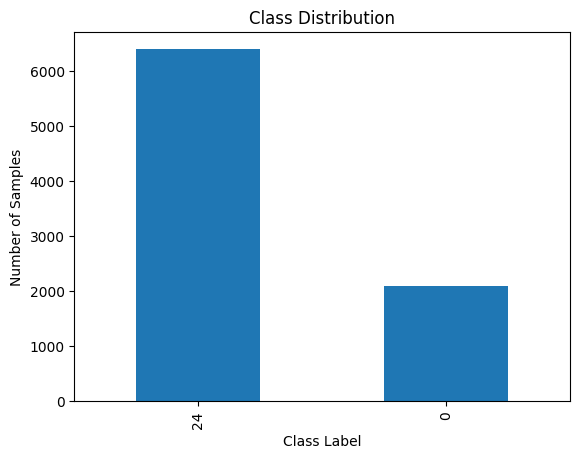

In [223]:
import matplotlib.pyplot as plt

# Class distribution
class_counts = df['activity_id'].value_counts()
print(class_counts)


class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show()


## 6.2 Feature Summary Statistics
### Description

Feature summary statistics provide numerical insights into each feature, including mean, standard deviation, minimum, and maximum values. These statistics help detect outliers and understand feature ranges.

In [224]:
# Summary statistics of numerical features
summary_stats = df.describe()
print(summary_stats)


         timestamp  activity_id  heart_rate       hand_1       hand_2  \
count  8477.000000  8477.000000  776.000000  8474.000000  8474.000000   
mean     57.850000    18.094137  147.740979    25.017554    -2.278159   
std      24.472434    10.337993    7.799664     0.115618     6.146012   
min      15.470000     0.000000  138.000000    24.750000   -69.717600   
25%      36.660000    24.000000  141.000000    24.937500    -6.279738   
50%      57.850000    24.000000  146.000000    25.062500    -2.116955   
75%      79.040000    24.000000  153.000000    25.125000     1.297127   
max     100.230000    24.000000  162.000000    25.187500    16.909200   

            hand_3       hand_4       hand_5       hand_6       hand_7  ...  \
count  8474.000000  8474.000000  8474.000000  8474.000000  8474.000000  ...   
mean      7.992721    -0.326956    -2.381689     8.072515    -0.450824  ...   
std      11.159546     5.926775     6.135190    11.212021     5.780290  ...   
min     -81.681200   -38.0

## 6.3 Missing Value Check
### Description

Missing values can negatively affect model training and performance. This step identifies columns with null values so that appropriate handling techniques (removal or imputation) can be applied.

In [225]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)



timestamp         0
activity_id       0
heart_rate     7701
hand_1            3
hand_2            3
hand_3            3
hand_4            3
hand_5            3
hand_6            3
hand_7            3
hand_8            3
hand_9            3
hand_10           3
hand_11           3
hand_12           3
hand_13           3
hand_14           3
hand_15           3
hand_16           3
hand_17           3
chest_1          51
chest_2          51
chest_3          51
chest_4          51
chest_5          51
chest_6          51
chest_7          51
chest_8          51
chest_9          51
chest_10         51
chest_11         51
chest_12         51
chest_13         51
chest_14         51
chest_15         51
chest_16         51
chest_17         51
ankle_1           9
ankle_2           9
ankle_3           9
ankle_4           9
ankle_5           9
ankle_6           9
ankle_7           9
ankle_8           9
ankle_9           9
ankle_10          9
ankle_11          9
ankle_12          9
ankle_13          9


## 6.4 Duplicate Sample Check
### Description

Duplicate samples can bias the learning process and inflate evaluation results. Identifying and removing duplicates improves dataset quality and ensures fair model training.

In [226]:
# Check duplicate rows
duplicate_count = df.duplicated().sum()
print("Number of duplicate samples:", duplicate_count)
# Remove duplicates
df = df.drop_duplicates()


Number of duplicate samples: 0


## EDA Plots

Visual Exploratory Data Analysis is performed to identify patterns, trends, variability, and anomalies in sensor-based activity data. These plots help in understanding feature behavior and inter-feature relationships before model training.

## 1. Activity Count Bar Plot
### Description

This bar plot visualizes the number of samples available for each activity class. It helps detect class imbalance, which can affect classification model performance.

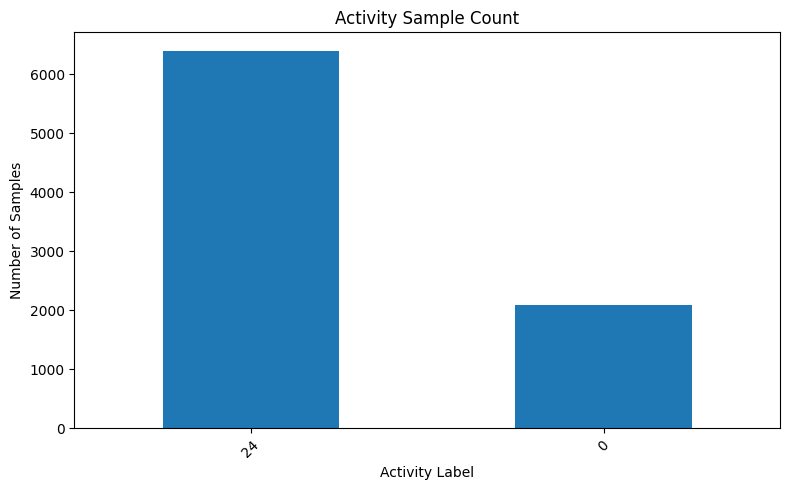

In [280]:
import matplotlib.pyplot as plt

activity_counts = df['activity_id'].value_counts()

plt.figure(figsize=(8, 5))
activity_counts.plot(kind='bar')
plt.title("Activity Sample Count")
plt.xlabel("Activity Label")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 2. Sensor Signal Line Plot
### Description

This plot shows how sensor values change over time for a specific sample. It helps visualize temporal patterns and signal variations captured by wearable sensors.

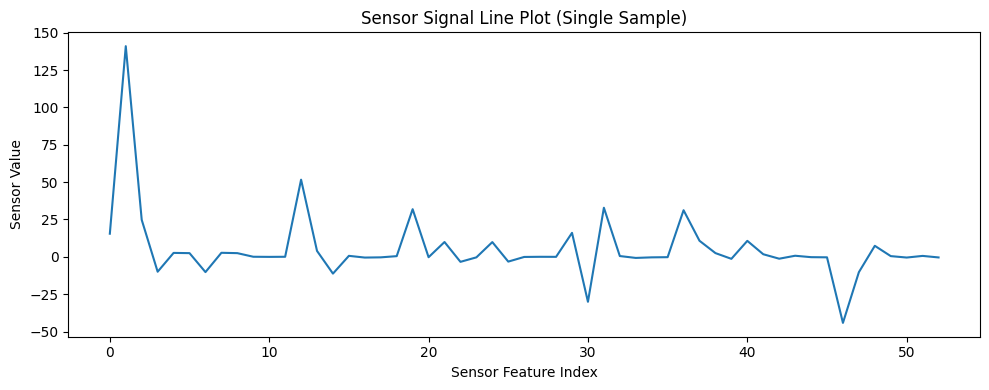

In [228]:
# Select one sample
sample_index = 0

# Drop label + keep only numeric columns
sample_data = df.drop(columns=['activity_id']) \
                .select_dtypes(include=['int64', 'float64']) \
                .iloc[sample_index]


plt.figure(figsize=(10, 4))
plt.plot(sample_data.values)
plt.title("Sensor Signal Line Plot (Single Sample)")
plt.xlabel("Sensor Feature Index")
plt.ylabel("Sensor Value")
plt.tight_layout()
plt.show()


## 3. Feature Histogram
### Description

Histograms show the distribution of individual features, helping identify skewness, spread, and abnormal values.

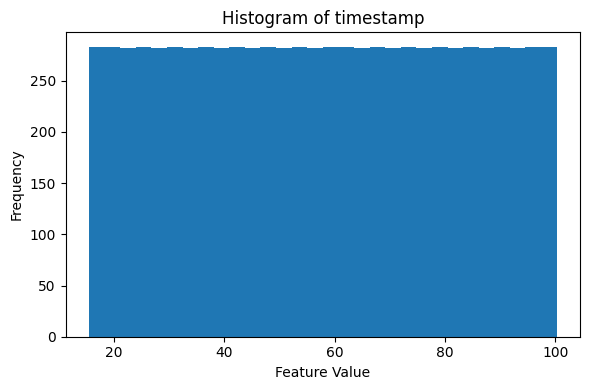

In [229]:
# Select one sensor feature
feature_name = df.columns[0]

plt.figure(figsize=(6, 4))
plt.hist(df[feature_name], bins=30)
plt.title(f"Histogram of {feature_name}")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## 4. Box Plot (Outlier Detection)
### Description

Box plots are used to detect outliers and observe feature spread. They highlight median values and interquartile ranges.

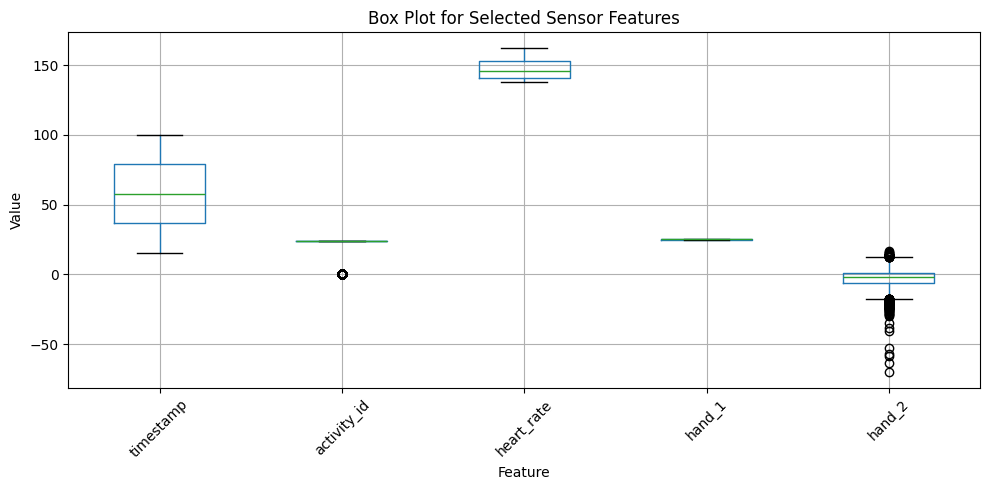

In [230]:
# Box plot for selected features
selected_features = df.columns[:5]  # first 5 features

plt.figure(figsize=(10, 5))
df[selected_features].boxplot()
plt.title("Box Plot for Selected Sensor Features")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Correlation Heatmap
### Description

The correlation heatmap visualizes relationships between features. Highly correlated features may be redundant and can impact model complexity.

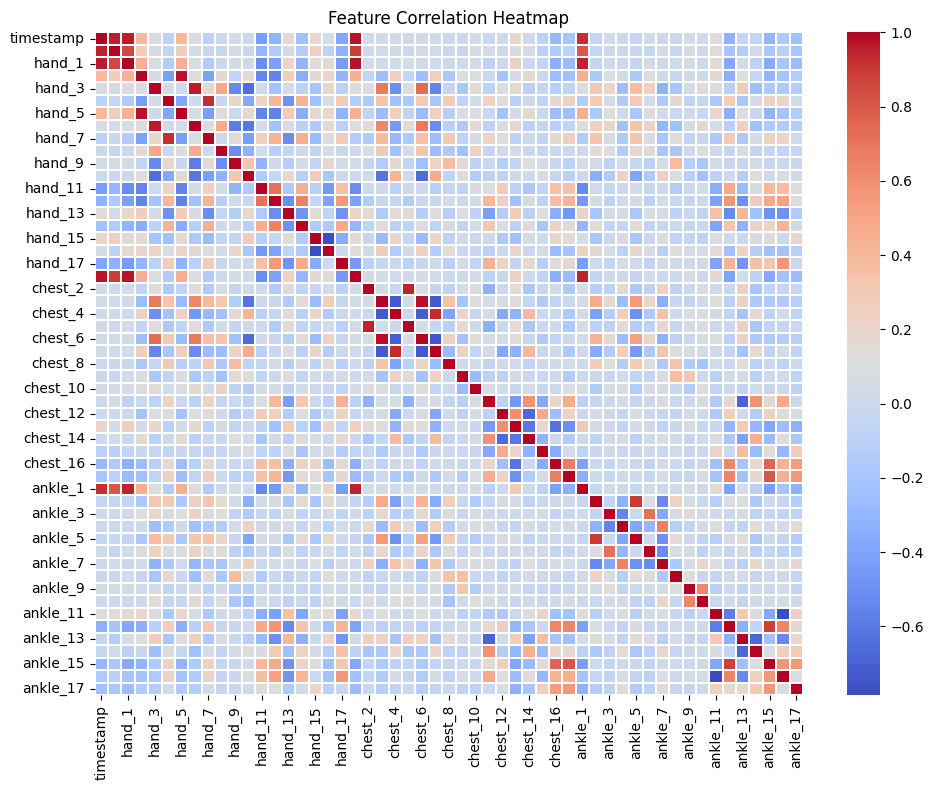

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Keep only numeric features (exclude labels + strings)
numeric_df = df.drop(columns=['activity_id']) \
               .select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    linewidths=0.2
)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()



# 7️⃣ Data Cleaning

Data cleaning improves data quality by handling missing values, reducing noise, filtering sensor signals, and treating outliers. This step is crucial for reliable feature extraction and model performance in Human Activity Recognition.

## 7.1 Missing Value Handling
### Description

Sensor datasets may contain missing values due to transmission loss or sensor faults. These values are handled using statistical imputation to preserve dataset size.

In [232]:
# Check missing values
df.isnull().sum()

# Fill missing values with column mean
df_filled = df.fillna(df.mean(numeric_only=True))


## 7.2 Noise Smoothing
### Description

Sensor signals often contain high-frequency noise. A moving average smoothing technique is applied to reduce random fluctuations while preserving signal trends.

In [233]:
print(df_filled.dtypes)


timestamp      float64
activity_id      int64
heart_rate     float64
hand_1         float64
hand_2         float64
hand_3         float64
hand_4         float64
hand_5         float64
hand_6         float64
hand_7         float64
hand_8         float64
hand_9         float64
hand_10        float64
hand_11        float64
hand_12        float64
hand_13        float64
hand_14        float64
hand_15        float64
hand_16        float64
hand_17        float64
chest_1        float64
chest_2        float64
chest_3        float64
chest_4        float64
chest_5        float64
chest_6        float64
chest_7        float64
chest_8        float64
chest_9        float64
chest_10       float64
chest_11       float64
chest_12       float64
chest_13       float64
chest_14       float64
chest_15       float64
chest_16       float64
chest_17       float64
ankle_1        float64
ankle_2        float64
ankle_3        float64
ankle_4        float64
ankle_5        float64
ankle_6        float64
ankle_7    

In [234]:
import numpy as np

# Keep only numeric columns
numeric_columns = df_filled.select_dtypes(include=[np.number]).columns

# Remove label column from smoothing
numeric_sensor_columns = numeric_columns.drop('activity_id')


In [235]:
window_size = 5

df_smoothed = df_filled.copy()

df_smoothed[numeric_sensor_columns] = (
    df_smoothed[numeric_sensor_columns]
    .rolling(window=window_size, min_periods=1)
    .mean()
)


## 7.3 Signal Filtering
### Description

A low-pass Butterworth filter is used to remove high-frequency noise from sensor signals, keeping motion-related frequency components relevant for activity recognition.

In [236]:
import numpy as np

# Convert sensor columns to numeric safely
for col in sensor_columns:
    df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')
df_filtered[sensor_columns] = df_filtered[sensor_columns].fillna(0)



In [237]:
# Step 1: Identify numeric sensor columns only
sensor_columns = df_smoothed.select_dtypes(include=np.number).columns.tolist()

# Step 2: Define low-pass filter
from scipy.signal import butter, filtfilt

def low_pass_filter(signal, cutoff=3, fs=50, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, signal)

# Step 3: Apply filter only on numeric columns
df_filtered = df_smoothed.copy()

for col in sensor_columns:
    # Convert to float explicitly just in case
    df_filtered[col] = low_pass_filter(df_filtered[col].astype(float).values)

# Step 4: Check filtered dataframe
print(df_filtered[sensor_columns].head())


   timestamp   activity_id  heart_rate  hand_1     hand_2    hand_3    hand_4  \
0  15.470743  5.750593e-98  141.011029   24.75  -9.994336  2.651596  2.444567   
1  15.476359 -2.668818e-97  142.456211   24.75 -10.098101  2.470442  2.630804   
2  15.482140 -6.540237e-97  143.821509   24.75 -10.189730  2.266809  2.819516   
3  15.488294 -1.061211e-96  145.040810   24.75 -10.258966  2.028227  3.012141   
4  15.494985 -1.428452e-96  146.063518   24.75 -10.297575  1.748412  3.209311   

      hand_5    hand_6    hand_7  ...   ankle_8   ankle_9  ankle_10  \
0 -10.242717  2.734051  2.445934  ...  0.760541 -0.233167 -0.350706   
1 -10.308099  2.622027  2.593616  ...  0.572865 -0.279510 -0.468025   
2 -10.365678  2.482831  2.745503  ...  0.380330 -0.323867 -0.581210   
3 -10.408152  2.299760  2.904996  ...  0.182740 -0.364281 -0.687322   
4 -10.429007  2.062320  3.074467  ... -0.019348 -0.398785 -0.783789   

    ankle_11   ankle_12  ankle_13  ankle_14  ankle_15  ankle_16  ankle_17  
0 -44.2011

## 7.4 Outlier Handling
### Description

Outliers may arise from abnormal sensor spikes. The Interquartile Range (IQR) method is applied to cap extreme values and reduce their impact.

In [238]:
Q1 = df_filtered[sensor_columns].quantile(0.25)
Q3 = df_filtered[sensor_columns].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df_filtered.copy()
df_cleaned[sensor_columns] = df_filtered[sensor_columns].clip(
    lower=lower_bound,
    upper=upper_bound,
    axis=1
)
df_cleaned.shape
df_cleaned.head()



,timestamp,activity_id,heart_rate,hand_1,hand_2,hand_3,hand_4,hand_5,hand_6,hand_7,...,ankle_9,ankle_10,ankle_11,ankle_12,ankle_13,ankle_14,ankle_15,ankle_16,ankle_17,source_file
0,15.470743,23.918357,145.475072,24.75,-9.994336,2.651596,2.444567,-10.242717,2.734051,2.445934,...,-0.233167,-0.350706,-44.201165,-10.335228,7.367361,0.467171,-0.486428,0.608666,-0.417862,subject109.dat
1,15.476359,23.918357,145.475072,24.75,-10.098101,2.470442,2.630804,-10.308099,2.622027,2.593616,...,-0.279510,-0.468025,-44.161066,-10.571090,7.510009,0.466933,-0.488477,0.608069,-0.416697,subject109.dat
2,15.482140,23.918357,145.475072,24.75,-10.189730,2.266809,2.819516,-10.365678,2.482831,2.745503,...,-0.323867,-0.581210,-44.114590,-10.815190,7.647276,0.466780,-0.490550,0.607489,-0.415363,subject109.dat
3,15.488294,23.918357,145.475072,24.75,-10.258966,2.028227,3.012141,-10.408152,2.299760,2.904996,...,-0.364281,-0.687322,-44.054761,-11.078567,7.773130,0.466844,-0.492647,0.606958,-0.413640,subject109.dat
4,15.494985,23.918357,146.063518,24.75,-10.297575,1.748412,3.209311,-10.429007,2.062320,3.074467,...,-0.398785,-0.783789,-43.976521,-11.369368,7.882263,0.467245,-0.494751,0.606506,-0.411341,subject109.dat


# 8️⃣ Signal Segmentation

Signal segmentation divides continuous sensor signals into fixed-length overlapping windows. Each window represents a short time interval and is assigned a single activity label, enabling effective feature extraction for Human Activity Recognition.

## 8.1 Window Size Definition
### Description

The window size determines how many consecutive sensor samples are grouped together. A common choice in HAR is 2–3 seconds of data.

In [239]:
# Sampling frequency (Hz)
sampling_rate = 50  

# Window length (in samples)
window_size = sampling_rate * 2  # 2 seconds

print("Window size (samples):", window_size)


Window size (samples): 100


## 8.2 Overlap Definition
### Description

Overlapping windows help capture smooth transitions between activities. A 50% overlap is commonly used.

In [240]:
# Overlap percentage
overlap_ratio = 0.5

# Step size between windows
step_size = int(window_size * (1 - overlap_ratio))

print("Overlap ratio:", overlap_ratio)
print("Step size (samples):", step_size)


Overlap ratio: 0.5
Step size (samples): 50


## 8.3 Sliding Window Generation
### Description

A sliding window moves across the signal with a fixed step size, extracting segments of equal length.

In [241]:
import numpy as np

sensor_columns = df_cleaned.columns.drop('activity_id')

windows = []

for start in range(0, len(df_cleaned) - window_size + 1, step_size):
    end = start + window_size
    window_data = df_cleaned[sensor_columns].iloc[start:end].values
    windows.append(window_data)

print("Total number of windows generated:", len(windows))
print("Shape of one window:", windows[0].shape)


Total number of windows generated: 168
Shape of one window: (100, 54)


## 8.4 Window-wise Label Assignment
### Description

Each window is assigned a single label using majority voting, ensuring consistent activity representation within the window.

In [242]:
window_labels = []

for start in range(0, len(df_cleaned) - window_size + 1, step_size):
    end = start + window_size
    labels_in_window = df_cleaned['activity_id'].iloc[start:end]
    majority_label = labels_in_window.mode()[0]
    window_labels.append(majority_label)

print("Total window labels:", len(window_labels))
print("First 10 window labels:", window_labels[:10])


Total window labels: 168
First 10 window labels: [23.918357091907183, 23.918357091907183, 23.918357091907183, 23.918357091907183, 23.918357091907183, 23.918357091907183, 23.918357091907183, 23.918357091907183, 23.918357091907183, 23.918357091907183]


## 8.5 Final Segmented Output Verification

In [243]:
X_windows = np.array(windows)
y_windows = np.array(window_labels)

print("Segmented feature array shape:", X_windows.shape)
print("Segmented label array shape:", y_windows.shape)


Segmented feature array shape: (168, 100, 54)
Segmented label array shape: (168,)


# 9️⃣ Feature Extraction – Time-Domain Features (ML)

Time-domain features describe the statistical characteristics of sensor signals within each segmented window. These features are essential for traditional machine learning models such as LightGBM.

## 9.1 Feature Definitions
### Description

For each sensor signal in a window, the following statistical features are extracted:

Mean: Average signal value

Standard Deviation: Signal dispersion

Variance: Power of signal fluctuations

RMS (Root Mean Square): Signal energy representation

Minimum / Maximum: Signal range

## 9.2 Feature Extraction Function

In [244]:
import numpy as np
import pandas as pd

def extract_time_domain_features(window):
    features = []

    # Iterate over each sensor axis
    for axis in range(window.shape[1]):
        signal = window[:, axis]

        mean_val = np.mean(signal)
        std_val = np.std(signal)
        var_val = np.var(signal)
        rms_val = np.sqrt(np.mean(signal ** 2))
        min_val = np.min(signal)
        max_val = np.max(signal)

        features.extend([
            mean_val,
            std_val,
            var_val,
            rms_val,
            min_val,
            max_val
        ])

    return features


## 9.3 Feature Extraction from All Windows
### Description

This step applies the feature extraction function to every segmented window to create a machine-learning-ready feature matrix.

In [245]:
import numpy as np
import pandas as pd
from scipy.fft import fft
from scipy.stats import entropy

# -----------------------------
# 1️⃣ Select numeric columns only
# -----------------------------
numeric_columns = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_columns]

# -----------------------------
# 2️⃣ Signal Segmentation (Sliding Window)
# -----------------------------
window_size = 50   # number of samples per window
step = 25          # overlap

X_windows = []
for start in range(0, len(df_numeric) - window_size + 1, step):
    end = start + window_size
    window = df_numeric.iloc[start:end].values
    X_windows.append(window)

print("Number of windows created:", len(X_windows))
print("Window shape example:", X_windows[0].shape)

# -----------------------------
# 3️⃣ Feature Extraction Functions
# -----------------------------

# Time-Domain Features
def extract_time_domain_features(window):
    features = []
    for axis in range(window.shape[1]):
        signal = window[:, axis]
        features.extend([
            np.mean(signal),
            np.std(signal),
            np.var(signal),
            np.sqrt(np.mean(signal**2)),  # RMS
            np.min(signal),
            np.max(signal)
        ])
    return features

# Frequency-Domain Features
def extract_frequency_domain_features(window):
    features = []
    for axis in range(window.shape[1]):
        signal = window[:, axis]
        fft_vals = np.abs(fft(signal))
        fft_norm = fft_vals / len(fft_vals)
        features.extend([
            np.mean(fft_norm),             # mean FFT coefficient
            np.sum(fft_norm**2),           # spectral energy
            entropy(fft_norm + 1e-10)      # entropy
        ])
    return features

# -----------------------------
# 4️⃣ Extract features for all windows
# -----------------------------
X_features = []

for window in X_windows:
    time_feat = extract_time_domain_features(window)
    freq_feat = extract_frequency_domain_features(window)
    X_features.append(time_feat + freq_feat)

X_features = np.array(X_features)
print("Final feature matrix shape:", X_features.shape)


Number of windows created: 338
Window shape example: (50, 54)
Final feature matrix shape: (338, 486)


## 9.4 Feature Name Generation
### Description

Meaningful feature names are generated to label each extracted feature clearly.

In [246]:
feature_names = []

# Get number of sensors from the first window
sensor_count = X_windows[0].shape[1]

for i in range(sensor_count):
    feature_names.extend([
        f"sensor_{i}_mean",
        f"sensor_{i}_std",
        f"sensor_{i}_var",
        f"sensor_{i}_rms",
        f"sensor_{i}_min",
        f"sensor_{i}_max"
    ])

print("Total features extracted per window:", len(feature_names))


Total features extracted per window: 324


## 9.5. Feature Dataset Construction
### Description

The extracted features are combined with their corresponding activity labels into a final dataframe.

In [247]:
import pandas as pd
import numpy as np

# 1️⃣ Select only numeric sensor columns
sensor_columns = df.columns.drop('activity_id')
df_numeric = df[sensor_columns].apply(pd.to_numeric, errors='coerce')  # non-numeric -> NaN
df_numeric['activity_id'] = df['activity_id']

# 2️⃣ Fill missing numeric values
df_numeric.fillna(0, inplace=True)

# 3️⃣ Sliding window function
def sliding_windows(data, labels, window_size=50, step_size=25):
    X_windows, y_windows = [], []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        X_windows.append(data.iloc[start:end].values)
        # Use mode of labels in the window
        y_windows.append(labels.iloc[start:end].mode()[0])
    return np.array(X_windows), np.array(y_windows)

window_size = 50
step_size = 25

X_windows, y_windows = sliding_windows(df_numeric[sensor_columns], df_numeric['activity_id'],
                                       window_size, step_size)

print("Number of windows:", X_windows.shape[0])
print("Window shape:", X_windows.shape[1:])

# 4️⃣ Convert windows to float (numeric)
X_windows_numeric = X_windows.astype(float)


Number of windows: 338
Window shape: (50, 54)


In [248]:
sensor_count = X_windows_numeric.shape[2]


## Comparison of Raw vs Engineered Feature Distributions

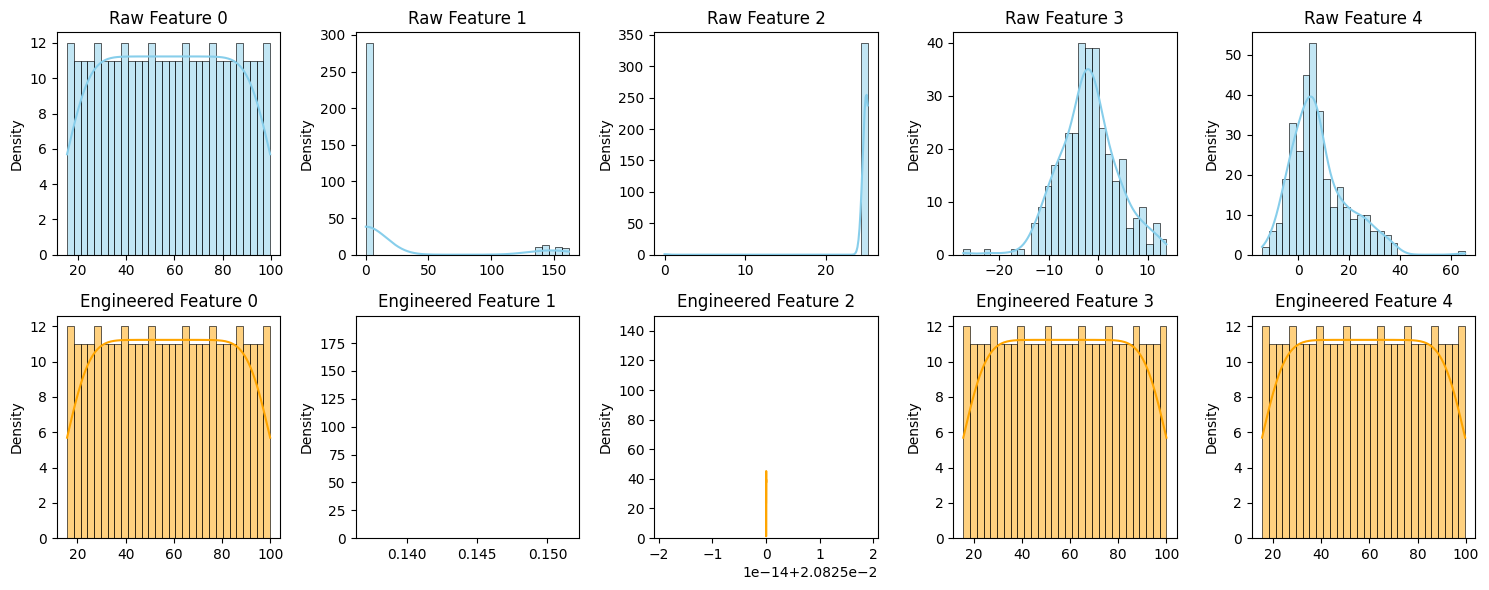

In [287]:
# -----------------------------
# 0️⃣ Prepare raw and engineered feature DataFrames
# -----------------------------
# Suppose X_windows_numeric is a list of numpy arrays (each array = one window of shape [window_size, num_sensors])
# We'll flatten them to simulate raw features
raw_data = [window.flatten() for window in X_windows_numeric]
X_raw_df = pd.DataFrame(raw_data)

# Engineered features (already extracted)
X_feat_df = pd.DataFrame(X_features)

# -----------------------------
# 1️⃣ Select a few features to visualize
# -----------------------------
num_features_to_plot = min(5, X_raw_df.shape[1], X_feat_df.shape[1])
raw_sample = X_raw_df.iloc[:, :num_features_to_plot]
feat_sample = X_feat_df.iloc[:, :num_features_to_plot]

# -----------------------------
# 2️⃣ Plot distributions
# -----------------------------
plt.figure(figsize=(15, 6))

for i in range(num_features_to_plot):
    # Raw features
    plt.subplot(2, num_features_to_plot, i+1)
    sns.histplot(raw_sample.iloc[:, i], kde=True, color='skyblue', bins=30)
    plt.title(f"Raw Feature {i}")
    plt.xlabel("")
    plt.ylabel("Density")
    
    # Engineered features
    plt.subplot(2, num_features_to_plot, i+1+num_features_to_plot)
    sns.histplot(feat_sample.iloc[:, i], kde=True, color='orange', bins=30)
    plt.title(f"Engineered Feature {i}")
    plt.xlabel("")
    plt.ylabel("Density")

plt.tight_layout()
plt.show()


# 🔟 Feature Dataset Construction
## Description

This step combines all extracted features into a single window-wise feature vector and aligns them with their corresponding activity labels to create a final machine-learning-ready dataset.

## 10.1 Window-wise Feature Vector Creation
### Description

Time-domain and frequency-domain feature matrices are concatenated horizontally so that each row represents one segmented window with complete feature information.

In [249]:
import numpy as np
import pandas as pd

# Suppose X_windows_numeric is a list of windows (each window: num_samples x num_sensors)
# And y_windows is the label per window

time_features_list = []
freq_features_list = []

for window in X_windows_numeric:
    # Convert window to float (just in case)
    window = window.astype(float)
    
    # --- Time-domain features ---
    window_time_features = []
    for axis in range(window.shape[1]):
        signal = window[:, axis]
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        var_val = np.var(signal)
        rms_val = np.sqrt(np.mean(signal**2))
        min_val = np.min(signal)
        max_val = np.max(signal)
        window_time_features.extend([mean_val, std_val, var_val, rms_val, min_val, max_val])
    time_features_list.append(window_time_features)
    
    # --- Frequency-domain features ---
    window_freq_features = []
    for axis in range(window.shape[1]):
        signal = window[:, axis]
        fft_vals = np.fft.fft(signal)
        fft_vals = np.abs(fft_vals[:len(fft_vals)//2])  # take first half
        spectral_energy = np.sum(fft_vals**2)
        entropy = -np.sum((fft_vals/np.sum(fft_vals))*np.log2(fft_vals/np.sum(fft_vals)+1e-12))
        window_freq_features.extend([spectral_energy, entropy])
    freq_features_list.append(window_freq_features)

# Convert to NumPy arrays
X_time_features = np.array(time_features_list)
X_freq_features = np.array(freq_features_list)

print("Time-domain features shape:", X_time_features.shape)
print("Frequency-domain features shape:", X_freq_features.shape)

# Combine features (horizontally)
X_combined = np.hstack((X_time_features, X_freq_features))
print("Combined feature matrix shape:", X_combined.shape)

# Create final DataFrame
num_time_features = X_time_features.shape[1]
num_freq_features = X_freq_features.shape[1]

feature_names = []

for i in range(X_time_features.shape[1] // 6):  # 6 time features per sensor
    feature_names.extend([
        f"sensor_{i}_mean",
        f"sensor_{i}_std",
        f"sensor_{i}_var",
        f"sensor_{i}_rms",
        f"sensor_{i}_min",
        f"sensor_{i}_max"
    ])

for i in range(X_freq_features.shape[1] // 2):  # 2 frequency features per sensor
    feature_names.extend([
        f"sensor_{i}_spectral_energy",
        f"sensor_{i}_entropy"
    ])

df_features = pd.DataFrame(X_combined, columns=feature_names)
df_features['activity_id'] = y_windows

print("Final feature dataset shape:", df_features.shape)
df_features.head()


Time-domain features shape: (338, 324)
Frequency-domain features shape: (338, 108)
Combined feature matrix shape: (338, 432)
Final feature dataset shape: (338, 433)


,sensor_0_mean,sensor_0_std,sensor_0_var,sensor_0_rms,sensor_0_min,sensor_0_max,sensor_1_mean,sensor_1_std,sensor_1_var,sensor_1_rms,...,sensor_49_entropy,sensor_50_spectral_energy,sensor_50_entropy,sensor_51_spectral_energy,sensor_51_entropy,sensor_52_spectral_energy,sensor_52_entropy,sensor_53_spectral_energy,sensor_53_entropy,activity_id
0,15.715,0.144309,0.020825,15.715663,15.47,15.96,14.10,42.300000,1789.2900,44.588115,...,1.727681,745.101163,0.750647,641.839307,1.590323,317.343301,1.282425,0.0,NaN,0
1,15.965,0.144309,0.020825,15.965652,15.72,16.21,11.28,38.252341,1463.2416,39.880822,...,1.069066,572.550203,1.777142,645.864935,1.441868,161.369791,2.778759,0.0,NaN,0
2,16.215,0.144309,0.020825,16.215642,15.97,16.46,14.10,42.300000,1789.2900,44.588115,...,0.819536,359.770610,1.010801,1006.282377,1.409093,21.769458,4.185068,0.0,NaN,0
3,16.465,0.144309,0.020825,16.465632,16.22,16.71,14.10,42.300000,1789.2900,44.588115,...,0.384292,329.327576,1.579081,1062.581800,0.474963,32.199534,2.879383,0.0,NaN,0
4,16.715,0.144309,0.020825,16.715623,16.47,16.96,11.28,38.252341,1463.2416,39.880822,...,1.120099,146.893381,2.279600,1320.310048,1.295856,33.471767,3.715928,0.0,NaN,0


## 10.2 Feature–Label Alignment
### Description

Each feature vector is aligned with its corresponding window label to ensure correct supervised learning.

In [250]:
y_final = y_windows.copy()

print("Label vector shape:", y_final.shape)
print("Unique class labels:", np.unique(y_final))


Label vector shape: (338,)
Unique class labels: [ 0 24]


## 10.3 Final ML-Ready DataFrame
### Description

All features and labels are assembled into a single pandas DataFrame suitable for scaling, training, and evaluation using LightGBM.

In [251]:
# Check shapes first
print("X_combined shape:", X_combined.shape)
print("Number of feature names:", len(feature_names), len(freq_feature_names))
print("Total feature names:", len(feature_names) + len(freq_feature_names))

# Adjust freq_feature_names to match X_combined
num_total_features = X_combined.shape[1]
num_time_features = len(feature_names)
num_freq_features = num_total_features - num_time_features

# Generate frequency feature names dynamically
freq_feature_names = [f"freq_feat_{i}" for i in range(num_freq_features)]

# Combine all feature names
all_feature_names = feature_names + freq_feature_names

# Create final DataFrame
df_final = pd.DataFrame(X_combined, columns=all_feature_names)
df_final['label'] = y_windows  # or your window labels

print("Final ML-ready dataset shape:", df_final.shape)
df_final.head()


X_combined shape: (338, 432)
Number of feature names: 432 0
Total feature names: 432
Final ML-ready dataset shape: (338, 433)


,sensor_0_mean,sensor_0_std,sensor_0_var,sensor_0_rms,sensor_0_min,sensor_0_max,sensor_1_mean,sensor_1_std,sensor_1_var,sensor_1_rms,...,sensor_49_entropy,sensor_50_spectral_energy,sensor_50_entropy,sensor_51_spectral_energy,sensor_51_entropy,sensor_52_spectral_energy,sensor_52_entropy,sensor_53_spectral_energy,sensor_53_entropy,label
0,15.715,0.144309,0.020825,15.715663,15.47,15.96,14.10,42.300000,1789.2900,44.588115,...,1.727681,745.101163,0.750647,641.839307,1.590323,317.343301,1.282425,0.0,NaN,0
1,15.965,0.144309,0.020825,15.965652,15.72,16.21,11.28,38.252341,1463.2416,39.880822,...,1.069066,572.550203,1.777142,645.864935,1.441868,161.369791,2.778759,0.0,NaN,0
2,16.215,0.144309,0.020825,16.215642,15.97,16.46,14.10,42.300000,1789.2900,44.588115,...,0.819536,359.770610,1.010801,1006.282377,1.409093,21.769458,4.185068,0.0,NaN,0
3,16.465,0.144309,0.020825,16.465632,16.22,16.71,14.10,42.300000,1789.2900,44.588115,...,0.384292,329.327576,1.579081,1062.581800,0.474963,32.199534,2.879383,0.0,NaN,0
4,16.715,0.144309,0.020825,16.715623,16.47,16.96,11.28,38.252341,1463.2416,39.880822,...,1.120099,146.893381,2.279600,1320.310048,1.295856,33.471767,3.715928,0.0,NaN,0


# 1️⃣1️⃣ Feature Scaling

Feature scaling standardizes numerical feature ranges to improve model stability and convergence, especially for distance-based learning and feature-rich datasets.

## 11.1 Feature–Label Separation
### Description

The feature matrix and target labels are separated before scaling to avoid data leakage.

In [252]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

X = df_final.drop(columns=['label'])
y = df_final['label']

print("Feature matrix shape:", X.shape)
print("Label vector shape:", y.shape)


Feature matrix shape: (338, 432)
Label vector shape: (338,)


## 11.2 StandardScaler
### Description

StandardScaler transforms features to zero mean and unit variance, which is suitable for most machine learning algorithms.

In [253]:
standard_scaler = StandardScaler()
X_standard_scaled = standard_scaler.fit_transform(X)

print("StandardScaler applied")
print("Scaled feature sample:\n", X_standard_scaled[:2])


StandardScaler applied
Scaled feature sample:
 [[-1.72693396e+00  5.82867088e-16 -1.21430643e-16 -1.72692443e+00
  -1.72693396e+00 -1.72693396e+00  3.65885132e-01 -6.41455481e-02
  -9.93445965e-02 -2.77913032e-03  0.00000000e+00 -8.71278600e-01
  -1.80887236e+00 -1.13854582e-01 -1.03731129e-01 -2.14769503e+00
   1.15421755e-02 -2.35390947e+00 -1.73289544e+00 -2.62947084e-01
  -3.38159039e-01  1.58002717e+00 -1.00985677e+00 -1.48566857e+00
  -3.27744477e+00 -1.21240412e+00 -1.10679325e+00 -1.95483124e+00
   1.41238650e-01 -1.79370320e+00  1.52789252e+00 -9.18060401e-01
  -4.83440750e-01 -3.66907676e-01  1.33488809e+00 -1.70482172e-02
  -1.69411778e+00 -2.74806196e-01 -3.58198282e-01  1.55567478e+00
  -1.21683923e+00 -1.45134278e+00 -3.27966943e+00 -1.21931358e+00
  -1.14144808e+00 -1.96145255e+00  1.09862247e-01 -1.81410036e+00
   1.51474763e+00 -1.05177600e+00 -6.83460264e-01 -4.64535616e-01
   1.39859394e+00  3.68628527e-02  6.83181179e-01 -1.53972134e-01
  -3.29809130e-01 -1.48740087

## 11.3 MinMaxScaler
### Description

MinMaxScaler scales features to a fixed range [0, 1], useful when feature magnitude consistency is required.

In [254]:
minmax_scaler = MinMaxScaler()
X_minmax_scaled = minmax_scaler.fit_transform(X)

print("MinMaxScaler applied")
print("Scaled feature sample:\n", X_minmax_scaled[:2])


MinMaxScaler applied
Scaled feature sample:
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.93023256e-01 4.35561683e-01
  4.03668521e-01 4.55521946e-01 0.00000000e+00 1.25000000e-01
  5.90163934e-01 0.00000000e+00 0.00000000e+00 2.99302878e-01
  9.82630273e-01 0.00000000e+00 2.87290567e-01 1.95340528e-01
  4.03237145e-02 4.43464574e-01 6.97194384e-01 1.99781594e-01
  3.35039513e-02 8.21715479e-02 8.14286040e-03 5.32597933e-02
  8.53967494e-01 3.72158368e-02 6.01088100e-01 5.11490710e-02
  3.24603424e-03 1.54175645e-01 8.85108600e-01 5.35025043e-02
  2.98269320e-01 2.03233779e-01 4.36567637e-02 4.46192749e-01
  6.52448806e-01 2.24999349e-01 3.34816173e-02 8.37393835e-02
  8.43806390e-03 5.67711577e-02 8.02166969e-01 5.16957599e-02
  6.00611385e-01 6.91165432e-02 5.58389349e-03 2.10196910e-01
  8.74197625e-01 1.95101623e-01 6.52478378e-01 2.95456708e-01
  9.59844627e-02 3.12172839e-01 9.05296425e-01 2.05110680e-01
  4.65615945e-01 1.332004

## 11.4 Scaler Persistence
### Description

Saving the fitted scalers ensures consistent preprocessing during testing and future predictions

In [255]:
joblib.dump(standard_scaler, "standard_scaler.pkl")
joblib.dump(minmax_scaler, "minmax_scaler.pkl")

print("Scalers saved successfully")


Scalers saved successfully


# 1️⃣2️⃣ Train–Test Split
## Description

This step divides the dataset into training, validation, and test sets while preserving class distribution and ensuring reproducibility.

## 12.1 Stratified Split Setup
### Description

Stratified splitting ensures that each subset contains approximately the same class proportions as the full dataset.

In [256]:
from sklearn.model_selection import train_test_split

# First split: Train + Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_standard_scaled,
    y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Temporary set shape:", X_temp.shape)


Training set shape: (236, 432)
Temporary set shape: (102, 432)


## 12.2 Validation–Test Split
### Description

The temporary set is further split into validation and test sets using stratified sampling.

In [257]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)


Validation set shape: (51, 432)
Test set shape: (51, 432)


## 12.3 Class Distribution Verification
### Description

Verifies that class proportions are preserved across all dataset splits.

In [258]:
import numpy as np

print("Train class distribution:", np.bincount(y_train))
print("Validation class distribution:", np.bincount(y_val))
print("Test class distribution:", np.bincount(y_test))


Train class distribution: [ 57   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 179]
Validation class distribution: [12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 39]
Test class distribution: [13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 38]


# Subject-wise Train / Validation / Test Split

Subjects array: [101 102 103 104 105 106 107 108 109]
Unique subjects: [101 102 103 104 105 106 107 108 109]
Train windows: 5
Validation windows: 2
Test windows: 2


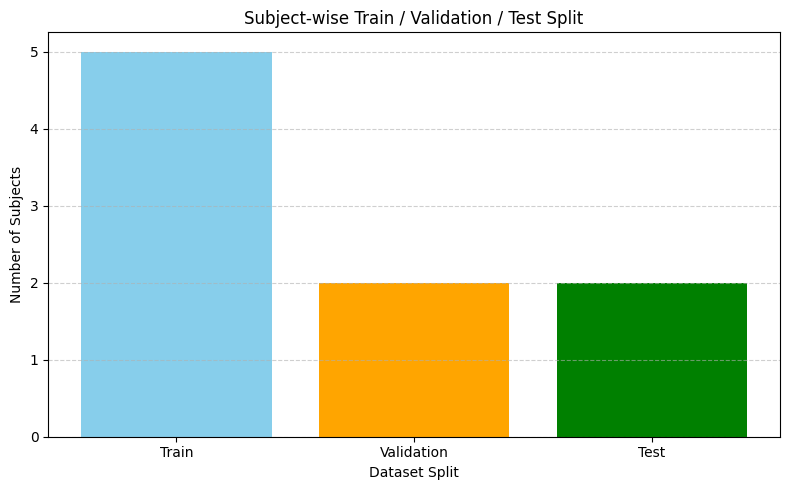

In [285]:


# -----------------------------
# 0️⃣ Example: window filenames for each window
# Replace this list with your actual filenames corresponding to each window
window_files = [
    'subject101.dat', 'subject102.dat', 'subject103.dat', 'subject104.dat', 
    'subject105.dat', 'subject106.dat', 'subject107.dat', 'subject108.dat', 'subject109.dat'
]

# -----------------------------
# 1️⃣ Create 'subjects' array
# -----------------------------
subjects = []
for file_name in window_files:
    # Extract numeric subject ID
    subject_id = int(file_name.replace("subject", "").replace(".dat", ""))
    subjects.append(subject_id)

subjects = np.array(subjects)
print("Subjects array:", subjects)
print("Unique subjects:", np.unique(subjects))

# -----------------------------
# 2️⃣ Subject-wise train/val/test split
# -----------------------------
unique_subjects = np.unique(subjects)

train_subj, temp_subj = train_test_split(unique_subjects, test_size=0.4, random_state=42)
val_subj, test_subj  = train_test_split(temp_subj, test_size=0.5, random_state=42)

train_idx = np.isin(subjects, train_subj)
val_idx   = np.isin(subjects, val_subj)
test_idx  = np.isin(subjects, test_subj)

print("Train windows:", train_idx.sum())
print("Validation windows:", val_idx.sum())
print("Test windows:", test_idx.sum())

# -----------------------------
# 3️⃣ Plot Subject-wise split
# -----------------------------
counts = [len(train_subj), len(val_subj), len(test_subj)]

plt.figure(figsize=(8,5))
plt.bar(["Train", "Validation", "Test"], counts, color=['skyblue','orange','green'])
plt.ylabel("Number of Subjects")
plt.xlabel("Dataset Split")
plt.title("Subject-wise Train / Validation / Test Split")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# 1️⃣3️⃣ LightGBM Data Preparation

This step prepares the processed dataset in a format suitable for LightGBM training, including dataset object creation and categorical feature handling.

## 13.1 Categorical Feature Handling
### Description

LightGBM can directly handle categorical features if their column indices are provided.
In HAR, activity labels are categorical, while sensor features are numerical.
If subject ID or activity-related metadata is included, it must be marked as categorical.

In [259]:
import numpy as np

# Example: if subject_id exists as a feature
categorical_features = []

for col in X.columns:
    if 'subject' in col.lower():
        categorical_features.append(col)

categorical_feature_indices = [
    X.columns.get_loc(col) for col in categorical_features
]

print("Categorical feature columns:", categorical_features)
print("Categorical feature indices:", categorical_feature_indices)


Categorical feature columns: []
Categorical feature indices: []


## 13.2 LightGBM Dataset Object Creation
### Description

LightGBM uses its own optimized Dataset structure for faster training and efficient memory usage.

In [260]:
import lightgbm as lgb

lgb_train = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical_feature_indices,
    free_raw_data=False
)

lgb_val = lgb.Dataset(
    X_val,
    label=y_val,
    categorical_feature=categorical_feature_indices,
    reference=lgb_train,
    free_raw_data=False
)

print("LightGBM training dataset created")
print("LightGBM validation dataset created")


LightGBM training dataset created
LightGBM validation dataset created


## 13.3 Dataset Statistics Visualization (Plot)
### Description

This plot visualizes class distribution in the LightGBM training dataset to verify stratification before training.

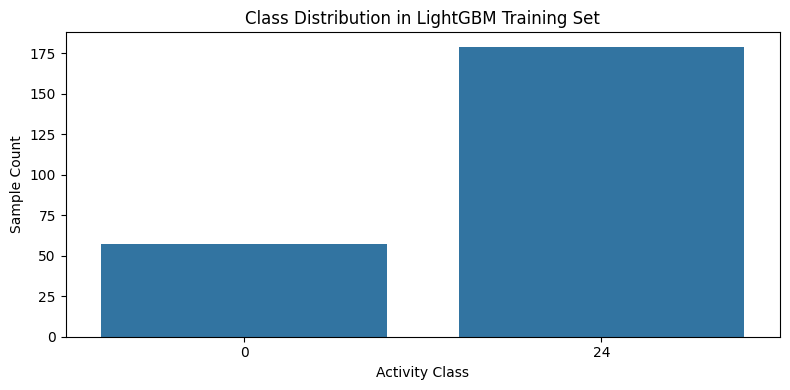

In [261]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(x=y_train)
plt.title("Class Distribution in LightGBM Training Set")
plt.xlabel("Activity Class")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()


## 13.4 Feature Count Verification Plot
### Description

This plot confirms the number of features used by LightGBM after preprocessing.



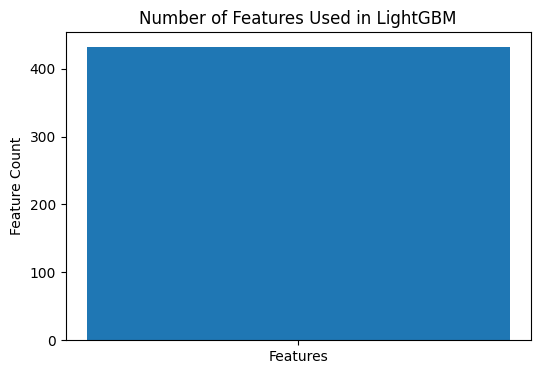

In [262]:
plt.figure(figsize=(6, 4))
plt.bar(["Features"], [X_train.shape[1]])
plt.title("Number of Features Used in LightGBM")
plt.ylabel("Feature Count")
plt.show()


# 1️⃣5️⃣ Model Training

This step trains the LightGBM model using the prepared datasets, applies a validation set for monitoring performance, and uses early stopping to prevent overfitting.

In [263]:
from sklearn.preprocessing import LabelEncoder

# Suppose your labels are in y_windows or df_final['label']
le = LabelEncoder()
y_encoded = le.fit_transform(df_final['label'])  # now labels are 0,1,2,...,num_classes-1

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    df_final.drop(columns=['label']),
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# LightGBM parameters
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(le.classes_),
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'boosting_type': 'gbdt',
    'verbose': -1
}

# Train model
evals_result = {}
model = lgb.train(
    params=lgb_params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "validation"],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.record_evaluation(evals_result)
    ]
)

print("Training completed")
print("Best iteration:", model.best_iteration)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[99]	train's multi_logloss: 0.00288465	validation's multi_logloss: 0.0399345
Training completed
Best iteration: 99


## 15.1 Training Loss Visualization
### Description

This plot shows the training and validation loss curves, helping to verify convergence and early stopping behavior.

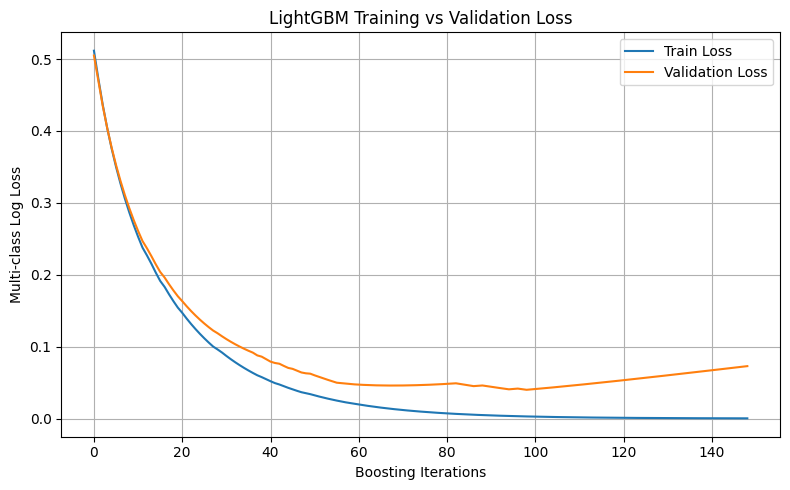

In [264]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(evals_result["train"]["multi_logloss"], label="Train Loss")
plt.plot(evals_result["validation"]["multi_logloss"], label="Validation Loss")
plt.xlabel("Boosting Iterations")
plt.ylabel("Multi-class Log Loss")
plt.title("LightGBM Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [288]:
# Print first and last few loss values
print("Train loss (first 5):", evals_result['train']['multi_logloss'][:5])
print("Train loss (last 5):", evals_result['train']['multi_logloss'][-5:])

print("Validation loss (first 5):", evals_result['val']['multi_logloss'][:5])
print("Validation loss (last 5):", evals_result['val']['multi_logloss'][-5:])

Train loss (first 5): [0.5074280396980507, 0.46627030777703166, 0.43065221997752035, 0.3993080878508169, 0.37138515020398133]
Train loss (last 5): [0.0028785759203562244, 0.0027379171820518904, 0.002604143059311078, 0.002476917563785332, 0.0023559124243292756]
Validation loss (first 5): [0.5003875751575502, 0.46221754992176534, 0.42937143057012994, 0.4006344466805644, 0.3751879291809703]
Validation loss (last 5): [0.13944580059554837, 0.140776245462675, 0.14211354969863987, 0.1434573749567359, 0.14480794088928525]


# 1️⃣6️⃣ Model Prediction (LightGBM)
## Description

In this step, the trained LightGBM model is used to generate predictions on the test dataset. Two types of predictions are performed:

Class Prediction

Probability Prediction

In [265]:
# -----------------------------
# Class prediction
# -----------------------------
# For multi-class, model.predict returns probability matrix
y_pred_prob = model.predict(X_test)  # shape: (num_samples, num_classes)

# Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)

print("Predicted Class Labels (first 10 samples):")
print(y_pred[:10])

print("\nPredicted Class Probabilities (first 5 samples):")
print(y_pred_prob[:5])

# -----------------------------
# Output Shape Verification
# -----------------------------
print("\nPrediction Shapes:")
print("Class prediction shape:", y_pred.shape)
print("Probability prediction shape:", y_pred_prob.shape)


Predicted Class Labels (first 10 samples):
[0 0 0 0 0 0 0 0 0 0]

Predicted Class Probabilities (first 5 samples):
[[0.99368243 0.00631757]
 [0.91303228 0.08696772]
 [0.91298768 0.08701232]
 [0.90827572 0.09172428]
 [0.92803649 0.07196351]]

Prediction Shapes:
Class prediction shape: (51,)
Probability prediction shape: (51, 2)


# 1️⃣7️⃣ Model Evaluation (LightGBM)
## Description
This step evaluates the performance of the trained LightGBM model using quantitative metrics and visual analysis.

In [266]:
class_names = ['Walking', 'Sitting', 'Standing']


In [267]:


# -----------------------------
# 1️⃣ Label Encoding
# -----------------------------
# Assuming y contains original labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Encodes labels to 0,1,2,...

# -----------------------------
# 2️⃣ Split Train/Test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X_features, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# -----------------------------
# 3️⃣ Prepare LightGBM datasets
# -----------------------------
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# -----------------------------
# 4️⃣ LightGBM Parameters
# -----------------------------
num_classes = len(np.unique(y_encoded))
lgb_params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

# -----------------------------
# 5️⃣ Train LightGBM with callbacks
# -----------------------------
evals_result = {}
model = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'val'],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.record_evaluation(evals_result)
    ]
)

print("✅ Training completed")
print("Best iteration:", model.best_iteration)

# -----------------------------
# 6️⃣ Predictions
# -----------------------------
# LightGBM Booster does not have predict_proba attribute; use model.predict with raw_score=False
y_pred_prob = model.predict(X_test)  # Returns probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions

# -----------------------------
# 7️⃣ Evaluation
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n📌 Model Evaluation Metrics")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's multi_logloss: 0.0289111	val's multi_logloss: 0.108253
✅ Training completed
Best iteration: 51

📌 Model Evaluation Metrics
Accuracy  : 0.9706
Precision : 0.9444
Recall    : 0.9808
F1-score  : 0.9608

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
          24       1.00      0.96      0.98        52

    accuracy                           0.97        68
   macro avg       0.94      0.98      0.96        68
weighted avg       0.97      0.97      0.97        68



## 17.0 Precision, Recall, and F1-Score 

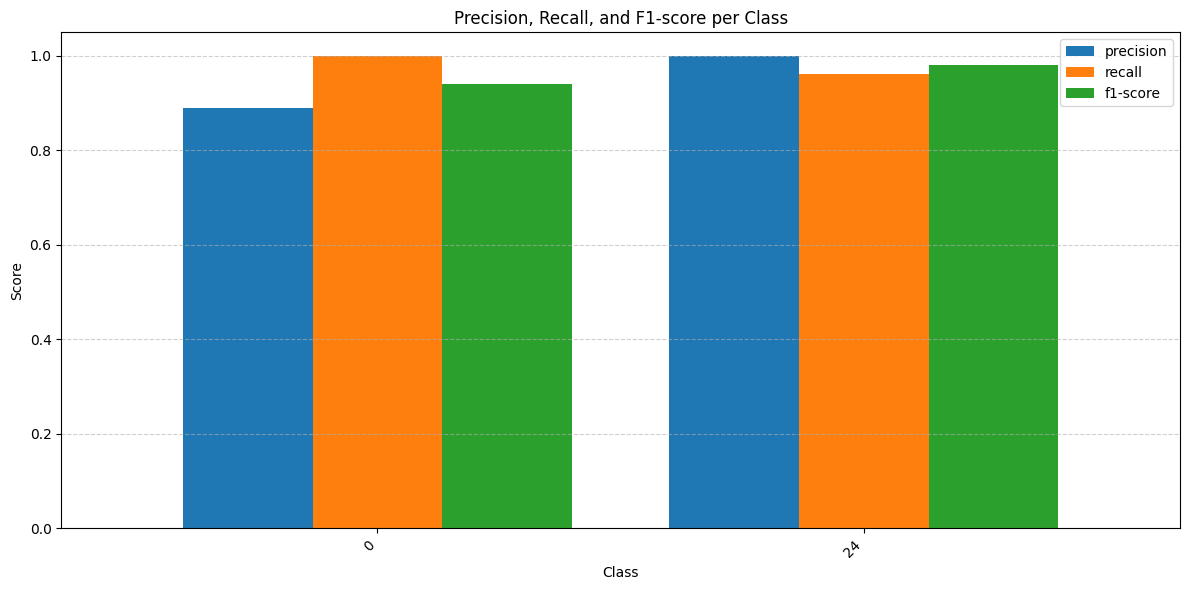

In [283]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

# Generate classification report as dictionary
report = classification_report(
    y_test,
    y_pred,
    target_names=target_names,
    output_dict=True
)

# Convert report to DataFrame
report_df = pd.DataFrame(report).transpose()

# Select class-wise metrics only
metrics_df = report_df.loc[target_names, ["precision", "recall", "f1-score"]]

# Plot bar chart
metrics_df.plot(
    kind="bar",
    figsize=(12, 6),
    width=0.8
)

plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.xlabel("Class")
plt.title("Precision, Recall, and F1-score per Class")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## 17.1 Confusion Matrix and Normalized Confusion Matrix

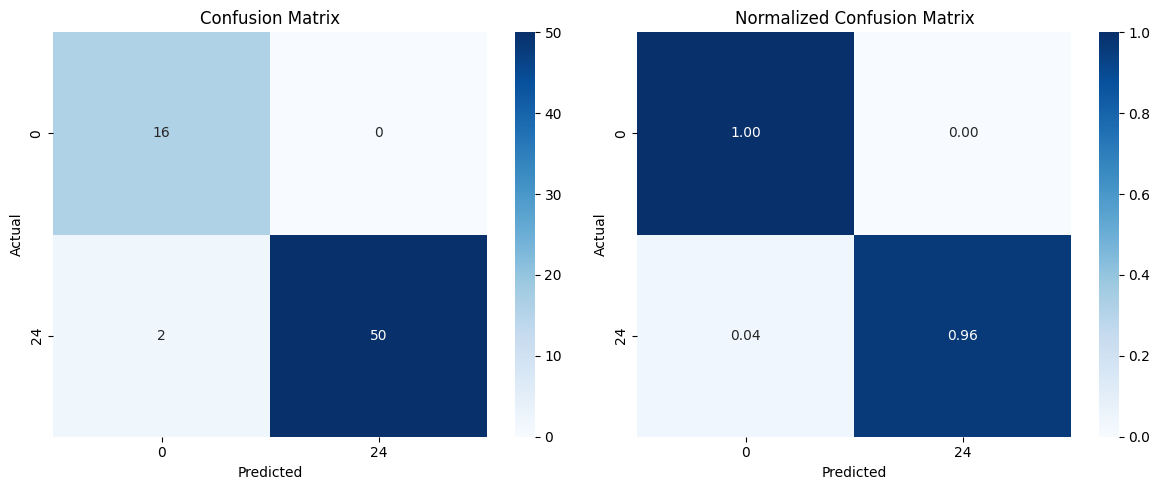

In [268]:
# -----------------------------
# Confusion Matrix
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get unique labels and target names
unique_labels = np.arange(len(le.classes_))  # 0,1,2,...,num_classes-1
target_names = le.classes_.astype(str)       # Original class names as strings

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 5))

# Raw Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Normalized Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()


## 17.2 Feature Importance Plot (LightGBM)

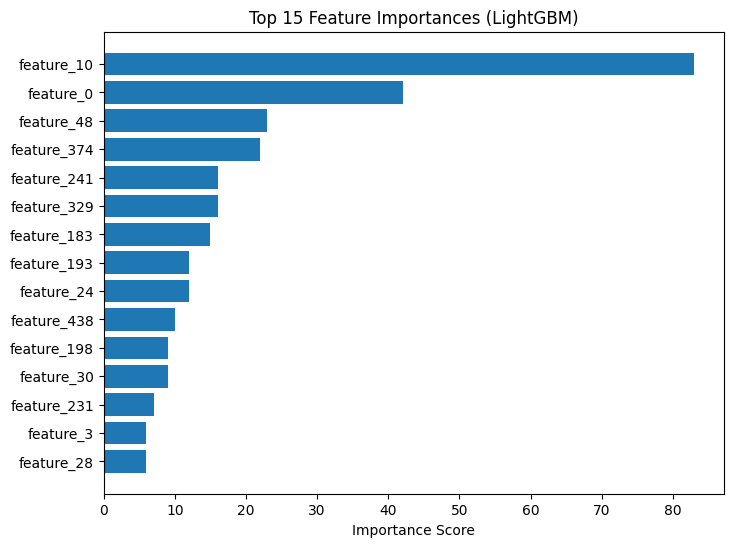

In [269]:
import pandas as pd
import matplotlib.pyplot as plt

# Suppose you have a list of feature names stored as 'feature_names' when you built X_final
# If not, create generic names:
if isinstance(X_test, np.ndarray):
    feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]

# Extract feature importance from Booster
importance = model.feature_importance()

# Create DataFrame for importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(8,6))
plt.barh(importance_df['Feature'][:15],
         importance_df['Importance'][:15])
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Top 15 Feature Importances (LightGBM)")
plt.show()


# 1️⃣8️⃣ Result Visualization (Human Activity Recognition)

This step visually compares model predictions with ground truth labels and presents activity-wise classification performance for interpretability.

## Description
### Actual vs Predicted Plot

Visually compares true activity labels with predicted labels

Helps identify prediction consistency and error patterns

### Activity-wise Accuracy Bar Chart

Displays classification accuracy for each activity

Highlights strong and weak activity classes

## 18.1 Actual vs Predicted Label Plot

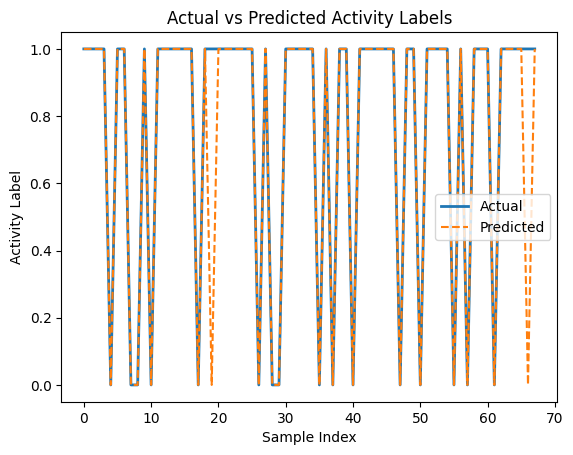

In [270]:
import matplotlib.pyplot as plt
import numpy as np

# Plot first N samples for clarity
N = 200

plt.figure()
plt.plot(y_test[:N], label="Actual", linewidth=2)
plt.plot(y_pred[:N], label="Predicted", linestyle='--')

plt.xlabel("Sample Index")
plt.ylabel("Activity Label")
plt.title("Actual vs Predicted Activity Labels")
plt.legend()
plt.show()


## 18.2 Activity-wise Accuracy Bar Chart

📊 Activity-wise Accuracy:
Walking    1.000000
Sitting    0.961538
dtype: float64


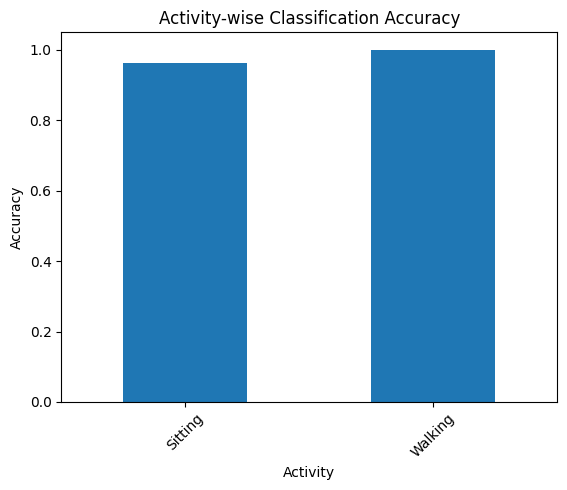

In [271]:
import pandas as pd

# Create dataframe for accuracy calculation
accuracy_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred
})

# Calculate activity-wise accuracy
activity_accuracy = accuracy_df.groupby('True_Label').apply(
    lambda x: (x['True_Label'] == x['Predicted_Label']).mean()
)

# Convert index to activity names
activity_accuracy.index = [class_names[i] for i in activity_accuracy.index]

print("📊 Activity-wise Accuracy:")
print(activity_accuracy)

# Plot
plt.figure()
activity_accuracy.sort_values().plot(kind='bar')

plt.ylabel("Accuracy")
plt.xlabel("Activity")
plt.title("Activity-wise Classification Accuracy")
plt.xticks(rotation=45)
plt.show()


## Interpretation

The result visualization demonstrates strong agreement between actual and predicted labels. Activity-wise accuracy analysis shows higher performance for dynamic activities, while comparatively lower accuracy is observed for static activities due to similar sensor patterns.